# 1. Постановка задачи

Данные представляют собой информацию о клиентах банка, связанную с их социально-демографическими характеристиками (возраст, работа, семейное положение, образование) и финансовым положением (баланс, наличие кредитов), а также с результатами маркетинговой кампании (была ли оформлена срочная депозитная ставка) в 2021 году.

## Условный заказчик
Заказчиком анализа выступает маркетинговый отдел банка. Их цель — повысить эффективность маркетинговых кампаний, сократив затраты на привлечение клиентов.

## Возможные задачи ИАД
- **Классификация**: Построение модели для предсказания того, оформит ли клиент депозит в будущем. Это позволит таргетировать рекламу только на потенциально заинтересованных клиентов.
- **Кластеризация / Сегментация клиентов**: Разделение клиентов на группы по их характеристикам . Это поможет лучше понять потребности каждой группы и разрабатывать для них персонализированные предложения.
- **Описательная аналитика**: Выявление ключевых факторов, влияющих на успех кампании.
- **Описательная аналитика**: Выявление ключевых факторов, влияющих на успех кампании. Например, выяснить, клиенты с каким образованием или семейным положением чаще всего соглашаются на предложение.

# 2. Паспорт датасета

In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/bank.csv', sep=';')

print(f"Всего строк: {df.shape[0]}, Всего столбцов: {df.shape[1]}")


Всего строк: 4521, Всего столбцов: 16


In [3]:
print("\nПервые пять строк:")
df.head()


Первые пять строк:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown


## Структура данных

In [4]:
print("\nИзначальные типы:")

for col in df.columns:
    dtype = df[col].dtype
    description = ""
    match col:
        case 'age':
            description = "Возраст"
        case 'job':
            description = "Тип работы"
        case 'marital':
            description = "Семейное положение "
        case 'education':
            description = "Уровень образования"
        case 'default':
            description = "Есть ли дефолт по кредиту? (yes, no)"
        case 'balance':
            description = "Среднегодовой баланс на счету"
        case 'housing':
            description = "Есть ли ипотечный кредит? (yes, no)"
        case 'loan':
            description = "Есть ли потребительский кредит? (yes, no)"
        case 'contact':
            description = "Тип контакта с клиентом"
        case 'day':
            description = "День последнего контакта."
        case 'month':
            description = "Месяц последнего контакт"
        case 'duration':
            description = "Длительность последнего контакта (в секундах)"
        case 'campaign':
            description = "Количество контактов с этим клиентом в рамках этой кампании"   
        case 'pdays':
            description = "Количество дней, прошедших после предыдущего контакта (-1 означает, что ранее не контактировали)"
        case 'previous':
            description = "Количество контактов с этим клиентом до этой кампании"
        case 'housing':
            description = "Есть ли ипотечный кредит? (yes, no)"
        case 'poutcome':
            description = "Результат предыдущей кампании"
    print(f"{col:<15} {str(dtype):<10} - {description}")


Изначальные типы:
age             int64      - Возраст
job             object     - Тип работы
marital         object     - Семейное положение 
education       object     - Уровень образования
default         object     - Есть ли дефолт по кредиту? (yes, no)
balance         int64      - Среднегодовой баланс на счету
housing         object     - Есть ли ипотечный кредит? (yes, no)
loan            object     - Есть ли потребительский кредит? (yes, no)
contact         object     - Тип контакта с клиентом
day             int64      - День последнего контакта.
month           object     - Месяц последнего контакт
duration        int64      - Длительность последнего контакта (в секундах)
campaign        int64      - Количество контактов с этим клиентом в рамках этой кампании
pdays           int64      - Количество дней, прошедших после предыдущего контакта (-1 означает, что ранее не контактировали)
previous        int64      - Количество контактов с этим клиентом до этой кампании
poutcome  

In [5]:
print("\nПреобразование типов к более подходящим:")

months = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
df['month_num'] = df['month'].map(months)

df['contact_date'] = pd.to_datetime(
    '2021' + df['month_num'].astype(str) + df['day'].astype(str).str.zfill(2),
    format='%Y%m%d',
)

df = df.drop(['day', 'month', 'month_num'], axis=1)

df['default'] = df['default'].astype('bool')
df['housing'] = df['housing'].astype('bool')
df['loan'] = df['loan'].astype('bool')

print("default, housing, loan: преобразованы в bool")

df['poutcome'] = df['poutcome'].astype('category')
print("poutcome: преобразован в category")

df['contact'] = df['contact'].astype('category')
print("contact: преобразован в category")

df['job'] = df['job'].astype('category')
df['marital'] = df['marital'].astype('category')
df['education'] = df['education'].astype('category')
print("job, marital, education: преобразованы в category")

print("\nИтоговые типы данных:")
print(df.dtypes)

print("\nПервые 5 строк с новой датой:")
print(df[['contact_date']].head())


Преобразование типов к более подходящим:
default, housing, loan: преобразованы в bool
poutcome: преобразован в category
contact: преобразован в category
job, marital, education: преобразованы в category

Итоговые типы данных:
age                      int64
job                   category
marital               category
education             category
default                   bool
balance                  int64
housing                   bool
loan                      bool
contact               category
duration                 int64
campaign                 int64
pdays                    int64
previous                 int64
poutcome              category
contact_date    datetime64[ns]
dtype: object

Первые 5 строк с новой датой:
  contact_date
0   2021-10-19
1   2021-05-11
2   2021-04-16
3   2021-06-03
4   2021-05-05


# 3. Аудит качества данных

## 3.1. Пропуски (Missing Values)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

missing_data = pd.DataFrame({
    'Количество пропусков': df.isnull().sum(),
    'Доля пропусков, %': (df.isnull().sum() / len(df) * 100).round(2)
})
print(missing_data)

print("\nНаиболее проблемные признаки:")
print(f"- contact: {missing_data.loc['contact', 'Доля пропусков, %']}% пропусков")
print(f"- poutcome: {missing_data.loc['poutcome', 'Доля пропусков, %']}% пропусков")

              Количество пропусков  Доля пропусков, %
age                              0               0.00
job                              0               0.00
marital                          0               0.00
education                        0               0.00
default                          0               0.00
balance                          0               0.00
housing                          0               0.00
loan                             0               0.00
contact                         33               0.73
duration                         0               0.00
campaign                         0               0.00
pdays                            0               0.00
previous                         0               0.00
poutcome                      1215              26.87
contact_date                     0               0.00

Наиболее проблемные признаки:
- contact: 0.73% пропусков
- poutcome: 26.87% пропусков


## Вывод:
contact: 0.73% пропусков - не критично.

poutcome: 26.87% пропусков - критично для сравнения с результатами предыдущей компании.

Остальные признаки: пропусков нет.

## 3.2. Дубликаты

In [7]:
full_duplicates = df.duplicated().sum()
print(f"Полностью дублирующихся строк: {full_duplicates}")

Полностью дублирующихся строк: 0


## 3.3. Типические проблемы значений

## Числовые признаки

In [8]:
numeric_cols = ['age', 'balance','duration','campaign', 'previous']
for col in numeric_cols:
    print(f"\n{col}:")
    print(f"  Min: {df[col].min()}")
    print(f"  Max: {df[col].max()}")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Std: {df[col].std():.2f}")
    print(f"  Медиана: {df[col].median():.2f}")
    
    if col == 'balance':
        negative = (df[col] < 0).sum()
        print(f"  Отрицательные значения: {negative}")
    if col == 'duration':
        negative = (df[col] < 0).sum()
        print(f"  Отрицательные значения времени: {negative}")



age:
  Min: 19
  Max: 87
  Mean: 41.17
  Std: 10.58
  Медиана: 39.00

balance:
  Min: -3313
  Max: 71188
  Mean: 1422.66
  Std: 3009.64
  Медиана: 444.00
  Отрицательные значения: 366

duration:
  Min: -1721
  Max: 3025
  Mean: 261.09
  Std: 262.75
  Медиана: 185.00
  Отрицательные значения времени: 22

campaign:
  Min: 1
  Max: 50
  Mean: 2.79
  Std: 3.11
  Медиана: 2.00

previous:
  Min: 0
  Max: 25
  Mean: 0.54
  Std: 1.69
  Медиана: 0.00


## Категориальные признаки

In [9]:
cat_cols = ['job', 'marital','education','contact', 'poutcome']
for col in cat_cols:
    unique_count = df[col].nunique()
    print(f"\n{col}:")
    print(f"  Уникальных значений: {unique_count}")
    
    if col == 'job':        
        leading_spaces = df[col].astype(str).str.startswith(' ').sum()
        print(f"  Значений с пробелами перед словом: {leading_spaces}")


job:
  Уникальных значений: 20
  Значений с пробелами перед словом: 16

marital:
  Уникальных значений: 3

education:
  Уникальных значений: 4

contact:
  Уникальных значений: 3

poutcome:
  Уникальных значений: 4


## 3.4. Выбросы (Outliers)

Выбросы (Outliers)

Анализ выбросов для balance:
Метод IQR (границы: [-2047.5, 3596.5]):
  Выбросов: 506 (11.19%)



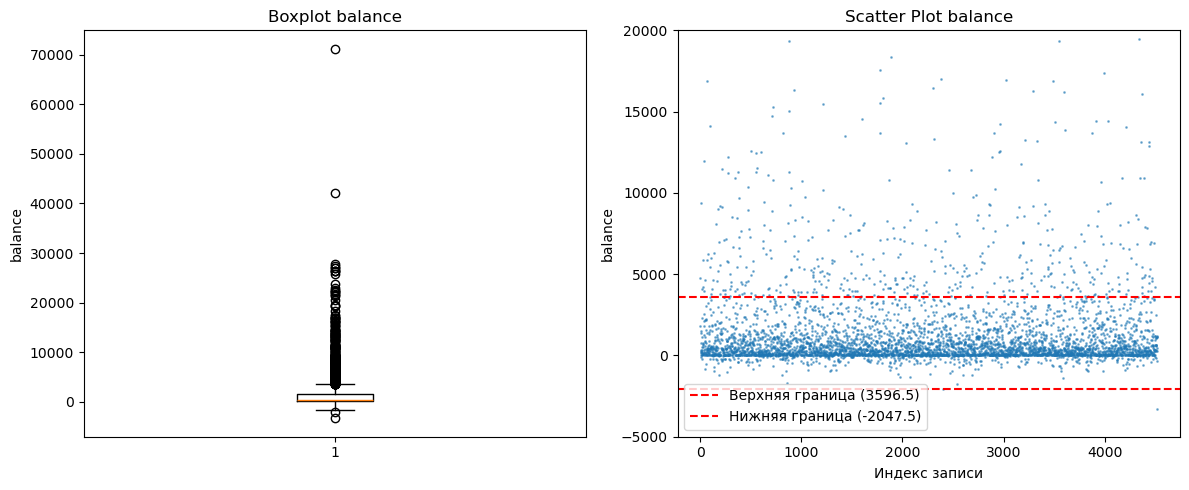

Анализ выбросов для duration:
Метод IQR (границы: [-232.0, 664.0]):
  Выбросов: 336 (7.43%)



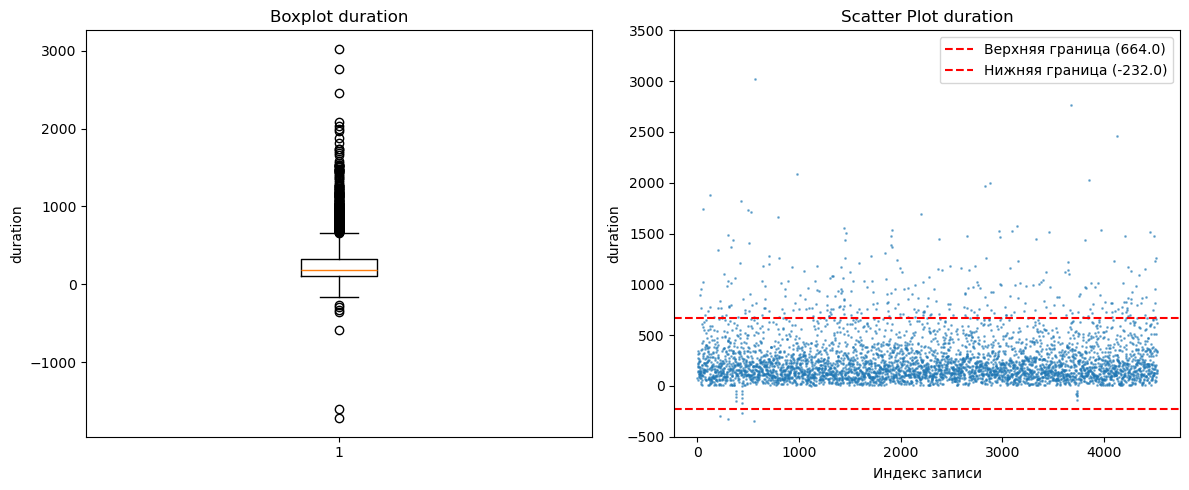

In [10]:
print("Выбросы (Outliers)\n")

outliers_cols = ['balance', 'duration']

for col in outliers_cols:
    print(f"Анализ выбросов для {col}:")
    
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_iqr = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Метод IQR (границы: [{lower_bound:.1f}, {upper_bound:.1f}]):")
    print(f"  Выбросов: {len(outliers_iqr)} ({len(outliers_iqr)/len(df)*100:.2f}%)\n")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].boxplot(df[col].dropna())
    axes[0].set_title(f'Boxplot {col}')
    axes[0].set_ylabel(col)
    
    axes[1].scatter(range(len(df)), df[col], alpha=0.5, s=1)
    axes[1].axhline(y=upper_bound, color='r', linestyle='--', label=f'Верхняя граница ({upper_bound:.1f})')
    axes[1].axhline(y=lower_bound, color='r', linestyle='--', label=f'Нижняя граница ({lower_bound:.1f})')
    axes[1].set_title(f'Scatter Plot {col}')
    axes[1].set_xlabel('Индекс записи')
    axes[1].set_ylabel(col)
    axes[1].legend()
    
    if col == 'balance':
        axes[1].set_ylim([-5000, 20000])
    elif col == 'duration':
        axes[1].set_ylim([-500, 3500])
    
    plt.tight_layout()
    plt.show()

# 4. Мини-EDA (разведочный анализ)

Распределение числового и категориального признака



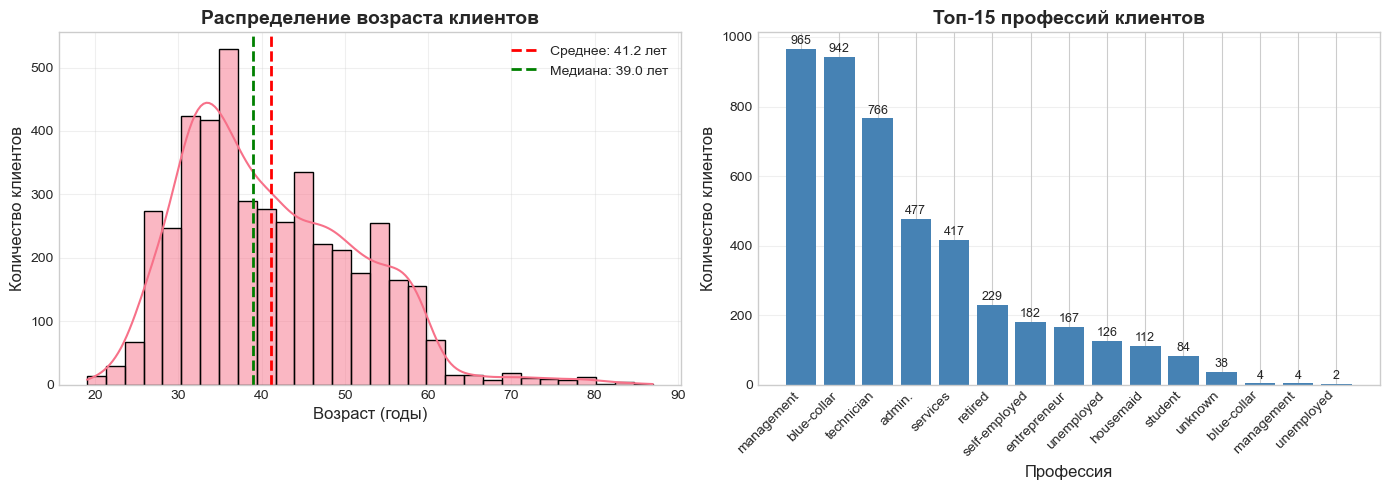

Комментарий к графику 1:
На левом графике видно, что большинство клиентов находятся в возрасте от 30 до 50 лет,
со средним значением 41.2 года. Медиана (39.0 лет) немного ниже среднего,
что указывает на небольшой перекос в сторону более молодых клиентов.

На правом графике видно, что самые распространенные профессии - management, blue-collar и technician,
которые вместе составляют более половины всех клиентов.

Гипотеза: Основная целевая аудитория банка - люди среднего возраста со стабильной работой
в сферах управления, рабочих специальностях и технических профессиях.
Вопрос: Как возраст и профессия клиентов влияют на их финансовое поведение
и вероятность оформления депозита?



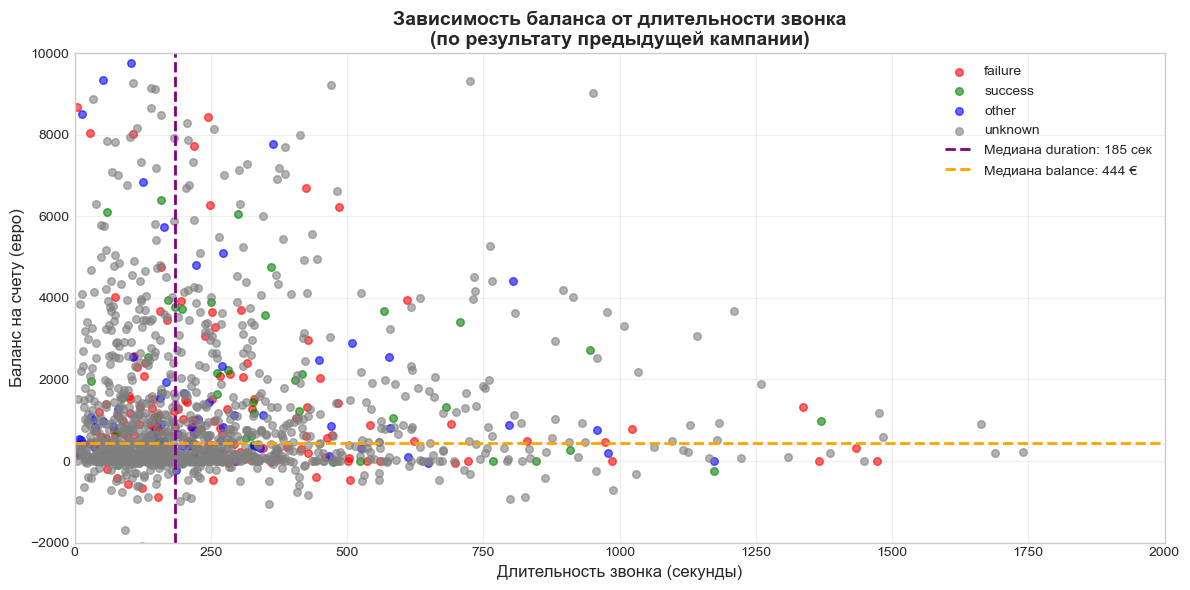

Всего в выборке: 1478 записей (после удаления пропусков)

Комментарий к графику 2:
Большинство точек сосредоточено в левой части графика (короткие звонки до 500 секунд)
и в нижней части (небольшой баланс до 2000 евро).
Успешные предыдущие кампании (зеленые точки) встречаются как при коротких, так и при длительных звонках.

Гипотеза: Длительность звонка может быть связана с успехом кампании - чем дольше разговор,
тем больше вероятность убедить клиента. Также видно, что клиенты с высоким балансом
встречаются реже, но именно среди них есть успешные кампании.

Вопрос: Какие факторы наиболее сильно влияют на успех кампании? Является ли длительность звонка
причиной успеха или просто следствием заинтересованности клиента?



In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Распределение числового и категориального признака\n")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]

sns.histplot(df['age'], kde=True, bins=30, ax=ax1)

mean_age = df['age'].mean()
median_age = df['age'].median()

ax1.axvline(mean_age, color='red', linestyle='--', linewidth=2,
            label=f'Среднее: {mean_age:.1f} лет')
ax1.axvline(median_age, color='green', linestyle='--', linewidth=2,
            label=f'Медиана: {median_age:.1f} лет')

ax1.set_title('Распределение возраста клиентов', fontsize=14, fontweight='bold')
ax1.set_xlabel('Возраст (годы)', fontsize=12)
ax1.set_ylabel('Количество клиентов', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]

top_jobs = df['job'].value_counts().head(15)

x_positions = range(len(top_jobs))
bars = ax2.bar(x_positions, top_jobs.values, color='steelblue')

ax2.set_xticks(x_positions)
ax2.set_xticklabels(top_jobs.index, rotation=45, ha='right')

for i, (bar, value) in enumerate(zip(bars, top_jobs.values)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(value), ha='center', va='bottom', fontsize=9)

ax2.set_title('Топ-15 профессий клиентов', fontsize=14, fontweight='bold')
ax2.set_xlabel('Профессия', fontsize=12)
ax2.set_ylabel('Количество клиентов', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Комментарий к графику 1:")
print("На левом графике видно, что большинство клиентов находятся в возрасте от 30 до 50 лет,")
print(f"со средним значением {mean_age:.1f} года. Медиана ({median_age:.1f} лет) немного ниже среднего,")
print("что указывает на небольшой перекос в сторону более молодых клиентов.")
print("\nНа правом графике видно, что самые распространенные профессии - management, blue-collar и technician,")
print("которые вместе составляют более половины всех клиентов.")
print("\nГипотеза: Основная целевая аудитория банка - люди среднего возраста со стабильной работой")
print("в сферах управления, рабочих специальностях и технических профессиях.")
print("Вопрос: Как возраст и профессия клиентов влияют на их финансовое поведение")
print("и вероятность оформления депозита?\n")

fig, ax = plt.subplots(figsize=(12, 6))

sample_size = min(2000, len(df))
sample_df = df.sample(sample_size, random_state=42).copy()

sample_df = sample_df.dropna(subset=['poutcome'])

color_dict = {'failure': 'red', 'success': 'green', 'other': 'blue', 'unknown': 'gray'}

sample_df['color'] = sample_df['poutcome'].astype(str).map(color_dict)

for outcome, color in color_dict.items():
    subset = sample_df[sample_df['poutcome'].astype(str) == outcome]
    ax.scatter(subset['duration'], subset['balance'],
               c=color, label=outcome, alpha=0.6, s=30)

ax.set_title('Зависимость баланса от длительности звонка\n(по результату предыдущей кампании)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Длительность звонка (секунды)', fontsize=12)
ax.set_ylabel('Баланс на счету (евро)', fontsize=12)

ax.set_xlim([0, 2000])
ax.set_ylim([-2000, 10000])

median_duration = df['duration'].median()
median_balance = df['balance'].median()

ax.axvline(median_duration, color='purple', linestyle='--', linewidth=2,
           label=f'Медиана duration: {median_duration:.0f} сек')
ax.axhline(median_balance, color='orange', linestyle='--', linewidth=2,
           label=f'Медиана balance: {median_balance:.0f} €')

ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Всего в выборке: {len(sample_df)} записей (после удаления пропусков)")

print("\nКомментарий к графику 2:")
print("Большинство точек сосредоточено в левой части графика (короткие звонки до 500 секунд)")
print("и в нижней части (небольшой баланс до 2000 евро).")
print("Успешные предыдущие кампании (зеленые точки) встречаются как при коротких, так и при длительных звонках.")
print("\nГипотеза: Длительность звонка может быть связана с успехом кампании - чем дольше разговор,")
print("тем больше вероятность убедить клиента. Также видно, что клиенты с высоким балансом")
print("встречаются реже, но именно среди них есть успешные кампании.")
print("\nВопрос: Какие факторы наиболее сильно влияют на успех кампании? Является ли длительность звонка")
print("причиной успеха или просто следствием заинтересованности клиента?\n")